In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [3]:
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''
     

#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')
     

#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

xmean,xstd = (tensor(0.28), tensor(0.35))

In [5]:
@inplace
def transformi(b):
    b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

In [6]:
tds = dsd.with_transform(transformi)
bs = 1024
dls = DataLoaders.from_dd(tds, bs, num_workers= 4)

In [7]:
xb, yb = next(iter(dls.train))
xb.mean(), xb.std()

(tensor(0.02), tensor(1.01))

In [8]:
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_valid=True): fc.store_attr()

    def before_batch(self,learn):
        if(self.on_train and learn.training) or (self.on_valid and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [9]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

In [10]:
class GeneralRelu(nn.Module):
    def __init__(self, leaky=None, subs=None, maxv=None):
        super().__init__()
        fc.store_attr()

    def forward(self, x):
        x = F.leaky_relu(x, self.leaky) if self.leaky is not None else F.relu(x)
        if self.subs is not None: x -= self.subs
        if self.maxv is not None:  x.clamp_max_(self.maxv)
        return x

In [11]:
def plot_func(f, start, end):
    x = torch.linspace(start, end, steps=100)
    plt.plot(x, f(x))
    plt.grid(True, 'both', ls='--')
    plt.axhline(y=0., color='k', linewidth=0.7)
    plt.axvline(x=0., color='k', linewidth=0.7)

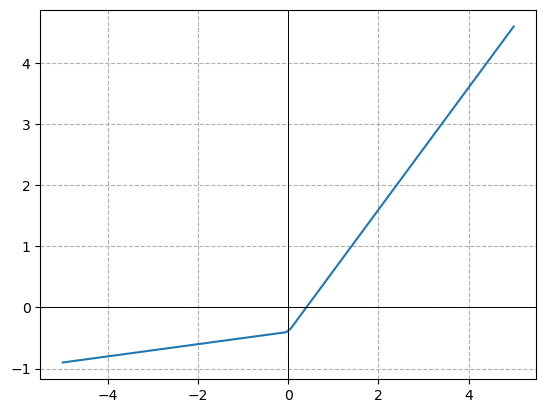

In [12]:
plot_func(GeneralRelu(leaky=0.1,subs=0.4), start=-5., end=5.)

In [13]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [14]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res
     

def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None), nn.Flatten()).to(def_device)

In [15]:
act_gr = partial(GeneralRelu, leaky=0.1,subs=0.4)
iw = partial(init_weights,leaky=0.1)
model = get_model(act_gr).apply(iw)

In [16]:
def _lsuv_stat(hook, mod, inp, out):
    act = to_device(out)
    hook.mean = act.mean()
    hook.std = act.std()

In [17]:
def lsuv_stat(model, m, m_in,xb):
    h = Hook(m, _lsuv_stat)
    with torch.no_grad():
        while (model(xb) is not None) and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -=h.mean
            m_in.weight.data /= h.std
        print("after", h.std, h.mean)
    h.remove()

In [18]:
act_gr = partial(GeneralRelu, leaky=0.1,subs=0.4)
model = get_model(act_gr).apply(iw)

In [19]:
act_layers = [l for l in model.modules() if isinstance(l, GeneralRelu)]
cnn_layers = [l for l in model.modules() if isinstance(l, nn.Conv2d)]

In [20]:
for ms in zip(act_layers, cnn_layers): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [21]:
for ms in zip(act_layers, cnn_layers): lsuv_stat(model, *ms, xb.to(def_device))

after tensor(1.00, device='cuda:0') tensor(0.00, device='cuda:0')
after tensor(1.00, device='cuda:0') tensor(0.00, device='cuda:0')
after tensor(1.00, device='cuda:0') tensor(0.00, device='cuda:0')
after tensor(1.00, device='cuda:0') tensor(0.00, device='cuda:0')


/home/metao/fastai2023/part2/.conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [22]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [48]:
def conv(ni, nf, ks=3, stride=2, norm=None, act=None, bias=None):
    if bias is None: not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    res = [nn.Conv2d(ni, nf, ks, stride,padding=ks//2, bias=bias)]
    if norm: res.append(norm(nf))
    if act: res.append(act())
    return nn.Sequential(*res)

In [49]:
def get_model(norm, act,nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i],nfs[i+1], norm=norm, act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers,conv(nfs[-1],10, norm=False, act=None, bias=True), nn.Flatten()).to(def_device)

In [52]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
act_gr = partial(GeneralRelu, leaky=0.1,subs=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

accuracy,loss,epoch,train
0.787,0.588,0,train
0.835,0.440,0,eval
0.869,0.362,1,train
0.848,0.399,1,eval
0.879,0.327,2,train
0.867,0.364,2,eval


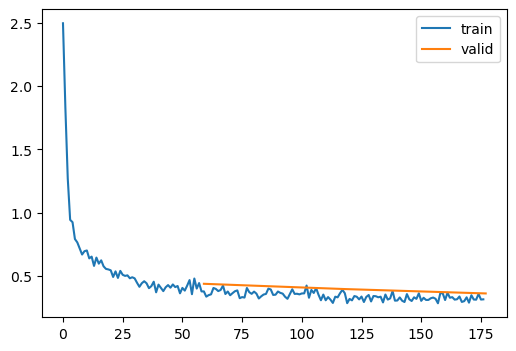

In [53]:
set_seed(42)
model = get_model(act=act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)